In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from footprint_poisson import footprint_poisson
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
FLAGS.batch_size = 128

# define flags (note that Fomoro will not pass any flags by default)
# flags.DEFINE_boolean('skip-training', False, 'If true, skip training the model.')
# flags.DEFINE_boolean('restore', False, 'If true, restore the model from the latest checkpoint.')

# define artifact directories where results from the session can be saved
model_path = os.environ.get('MODEL_PATH', 'models/')
checkpoint_path = os.environ.get('CHECKPOINT_PATH', 'checkpoints/')
summary_path = os.environ.get('SUMMARY_PATH', 'logs/')

"paths to the data sets"
pivotdir = "../data/"
dbdir = "../data/"

#infile = pivotdir+ "IGTB1077.batf_disc1.offsets_1000_1.pivot.tab"
#nrows = None
#ydf = pd.read_table(infile, index_col=[0,1], nrows = nrows)

dbpath = dbdir + "batf_disc1.offsets_1000_1.pivot.db"
import sqlite3
conn = sqlite3.connect(dbpath)

from match_dna_atac import get_aligned_batch, get_loader
#from itertools import cycle
train_batchloader = get_loader(conn, where={"chr": "chr21"})
test_batchloader = get_loader(conn, where="chr = 'chr22'")

#sys.exit(1)
trainsamples = 4000

tfl = footprint_poisson(
        sparsity = 1e-2,
        batch_norm = False,
        BATCH_SIZE = 2**8,
        dropout = 0.5,
        xlen = 2001,
        display_step = 100,
        xdepth = 4,
        weight_decay = 0.02583,
        conv1_channels = 128,
        conv2_channels = 32,
        tconv1_channels = 32,
        lr = 0.1,
        )

In [3]:
sess = tf.Session()
tfl._create_network()
tfl._load_(sess)
trvars = tf.trainable_variables()
trvars = {v.name:v for v in trvars}
print(trvars.keys())

x placeholder (?, 1, 2001, 4)
conv1 (?, 1, 2001, 128)
conv2 (?, 1, 2001, 32)
conv3 (?, 1, 2001, 32)
tconv1 [<tf.Tensor 'Squeeze:0' shape=() dtype=int32>, <tf.Tensor 'tconv1/sub_4:0' shape=() dtype=int32>, <tf.Tensor 'tconv1/sub_5:0' shape=() dtype=int32>, 32]
tconv2 [<tf.Tensor 'Squeeze:0' shape=() dtype=int32>, <tf.Tensor 'tconv2/sub_4:0' shape=() dtype=int32>, <tf.Tensor 'tconv2/sub_5:0' shape=() dtype=int32>, 1]


loading a session
checkpoint: model_checkpoint_path: "./checkpoints/model.ckpt-49"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-45"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-46"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-47"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-48"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-49"



dict_keys(['conv2/biases:0', 'conv1/biases:0', 'gate_2_3:0', 'tconv1/weights:0', 'conv3/biases:0', 'conv2/weights:0', 'conv1/weights:0', 'tconv2/weights:0', 'conv3/weights:0'])


In [8]:
x = trvars['conv1/weights:0']
xval = x.eval(sess)

In [9]:
xval[0].transpose(2,1,0).shape

(128, 4, 5)

In [24]:
from match_dna_atac import int_to_nucleotide
for ii in range(128):
    print("".join(list(np.vectorize(int_to_nucleotide)(np.argmax(xval[0,:,:,ii],axis=1)))) )

GAAGT
CATTC
CTTGA
AATGC
ACGCG
TACTC
TGCGA
AGTGA
CTGTT
GCGCT
GGGGG
AGGAG
ATATC
CGGTC
ATAGA
GTGCG
AACGA
GGTTA
TTATG
AGCGG
GCGGA
AATTT
TCTGG
AACGA
AGCTT
CGGTA
TAACC
TCAAG
GCGGT
CGCAG
CAGCA
TCCCT
TTAGT
AGCTT
GTCAT
AAAAG
CGACA
TGTTC
CCACG
CGATC
GAGTG
TTTTG
CCTTA
ATCTC
TAGGA
AAAGT
GCGTT
TAAAC
GTCAT
GCCGG
TTCAT
ATGAG
CTTAT
GACTC
GTAGC
AACTT
GCCTT
GGGGC
AGCGA
TCGTG
AGACC
TCCCA
TCAAG
CAGAT
TTTTA
AGAGC
AAAGT
GCCCC
TCTAA
TTGCG
GTCAA
ATGAA
TCCCT
ACCGT
TCTTG
ACGTG
GCATT
TAGAC
GGCGT
GCTCC
GCATG
TCATC
AGAAT
AGGCT
GGGTT
GAAAC
GGCTG
ACCTC
AGGTG
ACCTC
AACAG
CTCAA
CGTCT
TTCGG
GTCTT
TACAT
ACAAC
GTGAG
ATGGT
CGCAA
GTTTT
GGCTT
TGGGT
TCCTA
AGCTC
TCCTA
ATCAG
ACTGC
CACGA
TGAGT
GGTGG
CTACG
GACAC
CTAAG
TCAAG
TGCCC
AGTAC
ACAAA
CATAT
TCTAC
CGAAT
GGGTC
TAAGA
AAATC
GTCTC
TCGTG
ATTAT
GTGTG


ValueError: too many values to unpack (expected 1)

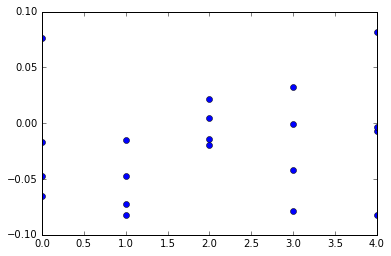

In [10]:
t = np.arange(5)
# plt.stem(t, xval[0].transpose(2,1,0)[0].T)
plt.stem(t, xval[0].transpose(2,1,0)[0].T,)

In [45]:
print("predicting")
test_batchloader = get_loader(conn, where="chr = 'chr22'", binary=False)
testbl = test_batchloader(500)
yhat_list = []
y_list = []
for nn, (xx, yy) in enumerate(testbl):
    tfl = footprint_poisson(
            sparsity = 1e-2,
            batch_norm = False,
            BATCH_SIZE = 2**8,
            dropout = 0.5,
            xlen = 2001,
            display_step = 100,
            xdepth = 4,
            weight_decay = 0.02583,
            conv1_channels = 128,
            conv2_channels = 32,
            tconv1_channels = 32,
            lr = 0.1,
            )

    print(nn)
    yhat = tfl.predict(xx)
    yhat_list.append(yhat)
    y_list.append(yy)
    break

predicting
0
x placeholder (?, 1, 2001, 4)
conv1 (?, 1, 2001, 128)
conv2 (?, 1, 2001, 32)
conv3 (?, 1, 2001, 32)
tconv1 [<tf.Tensor 'Squeeze:0' shape=() dtype=int32>, <tf.Tensor 'tconv1/sub_4:0' shape=() dtype=int32>, <tf.Tensor 'tconv1/sub_5:0' shape=() dtype=int32>, 32]
tconv2 [<tf.Tensor 'Squeeze:0' shape=() dtype=int32>, <tf.Tensor 'tconv2/sub_4:0' shape=() dtype=int32>, <tf.Tensor 'tconv2/sub_5:0' shape=() dtype=int32>, 1]


loading a session
checkpoint: model_checkpoint_path: "./checkpoints/model.ckpt-49"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-45"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-46"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-47"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-48"
all_model_checkpoint_paths: "./checkpoints/model.ckpt-49"



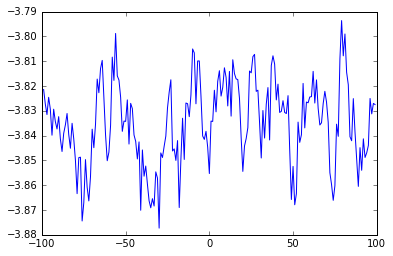

In [46]:
all_yhat = np.stack(yhat_list)
tt = np.arange(len(yhat[0])) - 1000
valid = abs(tt) < 100
plt.plot(tt[valid], (all_yhat.mean(0).mean(0)[valid]))


yhat_mean (2001,)
y_mean (2001,)
(2001,)
0.118739 0.162564


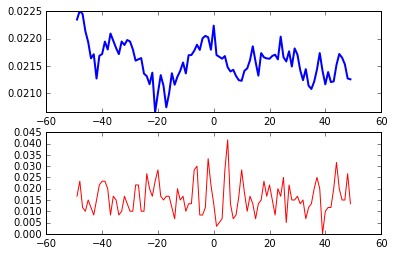

In [39]:
all_yhat = np.stack(yhat_list)
tt = np.arange(len(yhat[0])) - 1000
valid = abs(tt) < 50
yhat_mean = all_yhat.mean(0).mean(0)
print("yhat_mean", yhat_mean.shape)
yhat_var = all_yhat.reshape(-1, all_yhat.shape[-1]).var(0)
y_mean = np.mean(np.mean( np.stack(y_list), axis=0 ), axis=0)
print("y_mean", y_mean.shape)
print(yhat_var.shape)
fig, axs = plt.subplots(2)
axs[0].plot(tt[valid], np.exp(yhat_mean[valid]), c="b", zorder=1, lw=2 )
axs[0].plot(tt[valid], (yhat_var[valid]), c="g", zorder=2 )
axs[0].set_ylim(np.exp(np.r_[ min(yhat_mean[valid]), max(yhat_mean[valid]) ]))
print(min(yhat_var[valid]), max(yhat_var[valid]))
#axs[0].set_xlim([0, np.exp(max(yhat[0]))+0.01 ])
#for t_ in tt[ (y_mean>0) & valid]:
#    axs[0].axvline(t_, c='r')
#ax.scatter(tt, yy[0],c=(1,0,0,1), edgecolors="none", zorder=2 )
axs[1].plot(tt[valid], y_mean[valid], c='r')
#axs[1].stem(tt[valid], y_mean[valid], markerfmt='ro',linefmt='r-',
#            edgecolors="none", zorder=2 )
#axs[1].set_xlim([0, max(yy[0]+1)])